## Import packages 

In [1]:
# Let's import necessary packages
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA

import plotly.graph_objects as go

import matplotlib.pyplot as plt
import seaborn as sns

import re 

import warnings
warnings.filterwarnings('ignore')

random_seed = 101

## Read the data

In [2]:
# Let's read the data file
df = pd.read_csv("Data/6.3.3_spotify_5000_songs.csv")
df.head()

Unnamed: 0  \
0           0   
1           1   
2           2   
3           3   
4           4   

  name                                                                                                                                                                               \
0  Se Eu Quiser Falar Com Deus                   ...                                                                                                                                  
1  Saudade De Bahia                              ...                                                                                                                                  
2  Canta Canta, Minha Gente                      ...                                                                                                                                  
3  Mulher Eu Sei                                 ...                                                                                                                                  
4  Rosa Morena                                   ...                                                                                                                                  

   artist                                            danceability   energy     \
0  Gilberto Gil                                              0.658     0.2590   
1  Antônio Carlos Jobim                                      0.742     0.3990   
2  Martinho Da Vila                                          0.851     0.7300   
3  Chico César                                               0.705     0.0502   
4  Kurt Elling                                               0.651     0.1190   

   key   loudness   mode   speechiness   acousticness   instrumentalness   \
0    11    -13.141      0        0.0705          0.694           0.000059   
1     2    -12.646      1        0.0346          0.217           0.000002   
2     2    -11.048      1        0.3470          0.453           0.000063   
3     4    -18.115      1        0.0471          0.879           0.000041   
4     6    -19.807      1        0.0380          0.916           0.000343   

   liveness   valence   tempo     type   duration_ms   time_signature   \
0      0.975     0.306   110.376               256213                4   
1      0.107     0.693   125.039               191867                4   
2      0.124     0.905    93.698               152267                4   
3      0.386     0.524   106.802               186227                4   
4      0.104     0.402   120.941               273680                4   

   id                                                                    html  
0  1n7JnwviZ7zf0LR1tcGFq7   https://open.spotify.com/track/1n7JnwviZ7zf0LR...  
1  5QGM1U0eCYrQuwSJwTm5Zq   https://open.spotify.com/track/5QGM1U0eCYrQuwS...  
2  0NLIFSZxPzQhCwnkn5PJYs   https://open.spotify.com/track/0NLIFSZxPzQhCwn...  
3  3mXqOdlLE1k67WsAxryPFs   https://open.spotify.com/track/3mXqOdlLE1k67Ws...  
4  7bSzjzjTkWT2CkIPPdp0eA   https://open.spotify.com/track/7bSzjzjTkWT2CkI...

## Data cleaning

In [3]:
df.columns

Index(['Unnamed: 0',
       'name                                                                                                                                                                             ',
       'artist                                          ', 'danceability ',
       'energy   ', 'key ', 'loudness ', 'mode ', 'speechiness ',
       'acousticness ', 'instrumentalness ', 'liveness ', 'valence ',
       'tempo   ', 'type ', 'duration_ms ', 'time_signature ',
       'id                     ', 'html'],
      dtype='object')

In [4]:
# Clean spaces in column names
df.columns = df.columns.str.replace(" ", "")
df.columns

Index(['Unnamed:0', 'name', 'artist', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'type', 'duration_ms', 'time_signature',
       'id', 'html'],
      dtype='object')

In [5]:
# Drop unnecessary spaces from song and artist names
df['name'] = df['name'].str.strip()
df['artist'] = df['artist'].str.strip()

# Drop 'Unnamed:0'
df = df.drop(columns=['Unnamed:0'], axis=1)

# Check for duplicates
duplicate_rows = df[df.duplicated(["id"], keep="first")]
# pd.DataFrame(duplicate_rows)
print("The total num of duplicates is: ", len(duplicate_rows))

The total num of duplicates is:  64


In [6]:
# Create a copy
df2 = df.copy()

# Drop duplicates
df2.duplicated().value_counts()
df2 = df2.drop_duplicates()

In [7]:
# Set index
df2 = df2.set_index("id")

In [8]:
df2.info()
# No missing, but 2 non-numerical columns "type" and "html"

<class 'pandas.core.frame.DataFrame'>
Index: 5171 entries, 1n7JnwviZ7zf0LR1tcGFq7  to 7E1ErYYCn0lYjHODZ1qGuB 
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              5171 non-null   object 
 1   artist            5171 non-null   object 
 2   danceability      5171 non-null   float64
 3   energy            5171 non-null   float64
 4   key               5171 non-null   int64  
 5   loudness          5171 non-null   float64
 6   mode              5171 non-null   int64  
 7   speechiness       5171 non-null   float64
 8   acousticness      5171 non-null   float64
 9   instrumentalness  5171 non-null   float64
 10  liveness          5171 non-null   float64
 11  valence           5171 non-null   float64
 12  tempo             5171 non-null   float64
 13  type              5171 non-null   object 
 14  duration_ms       5171 non-null   int64  
 15  time_signature    5171 non-null   int64  
 16  html  

In [9]:
# Function to remove outliers using IQR method
def remove_outliers_iqr(df, col, multiplier=1.5):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    return df.loc[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

In [10]:
# Remove outliers
col_list_complete = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

# Remove outliers for each column
for col in df2[col_list_complete]:
    df3 = remove_outliers_iqr(df2, col, multiplier=1.5)

# Calculate the percentage of data retained
percentage_retained = (len(df3) / len(df2)) * 100

# Display the results
print(f"Number of rows before removing outliers: {len(df2)}")
print(f"Number of rows after removing outliers: {len(df3)}")
print(f"Percentage of data retained: {percentage_retained:.2f}%")

Number of rows before removing outliers: 5171
Number of rows after removing outliers: 5122
Percentage of data retained: 99.05%


In [11]:
df3.columns

Index(['name', 'artist', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'type', 'duration_ms', 'time_signature', 'html'],
      dtype='object')

## Scaling the data

In [12]:
# Use MinMaxScaler()
df3_new = df3.loc[:, col_list_complete]
print(df3_new.columns)
scaler = MinMaxScaler().set_output(transform="pandas")
df3_minmax_test = scaler.fit_transform(df3_new)
df3_minmax_test

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo'],
      dtype='object')


danceability    energy       key  loudness  mode  \
id                                                                          
1n7JnwviZ7zf0LR1tcGFq7       0.659467  0.258985  1.000000  0.683418   0.0   
5QGM1U0eCYrQuwSJwTm5Zq       0.752039  0.398988  0.181818  0.694238   1.0   
0NLIFSZxPzQhCwnkn5PJYs       0.872162  0.729995  0.181818  0.729168   1.0   
3mXqOdlLE1k67WsAxryPFs       0.711263  0.050181  0.363636  0.574692   1.0   
7bSzjzjTkWT2CkIPPdp0eA       0.651752  0.118982  0.545455  0.537707   1.0   
...                               ...       ...       ...       ...   ...   
1aEhYlZtypmipA06SDJ4U3       0.156932  0.069381  0.272727  0.459386   1.0   
1Gfqe7TAKklmuZf6hxsH6h       0.141503  0.100982  0.545455  0.492546   1.0   
2XNwnFrdMDpismp0VUZ7cU       0.000000  0.000910  0.818182  0.031630   1.0   
7ucDwgMtE3YJtEfTbuRhy0       0.080890  0.020780  0.363636  0.327074   1.0   
7E1ErYYCn0lYjHODZ1qGuB       0.324443  0.048681  0.454545  0.433636   1.0   

                         speechiness  acousticness  instrumentalness  \
id                                                                     
1n7JnwviZ7zf0LR1tcGFq7      0.053496      0.696787          0.000060   
5QGM1U0eCYrQuwSJwTm5Zq      0.013402      0.217871          0.000002   
0NLIFSZxPzQhCwnkn5PJYs      0.362296      0.454819          0.000064   
3mXqOdlLE1k67WsAxryPFs      0.027362      0.882530          0.000041   
7bSzjzjTkWT2CkIPPdp0eA      0.017199      0.919679          0.000348   
...                              ...           ...               ...   
1aEhYlZtypmipA06SDJ4U3      0.027585      0.920683          0.725888   
1Gfqe7TAKklmuZf6hxsH6h      0.024123      0.858434          0.432487   
2XNwnFrdMDpismp0VUZ7cU      0.023230      0.954819          0.983756   
7ucDwgMtE3YJtEfTbuRhy0      0.021555      0.886546          0.512690   
7E1ErYYCn0lYjHODZ1qGuB      0.010833      0.786145          0.491371   

                         liveness   valence     tempo  
id                                                     
1n7JnwviZ7zf0LR1tcGFq7   0.987706  0.296665  0.456665  
5QGM1U0eCYrQuwSJwTm5Zq   0.098453  0.697535  0.555779  
0NLIFSZxPzQhCwnkn5PJYs   0.115869  0.917133  0.343930  
3mXqOdlLE1k67WsAxryPFs   0.384284  0.522478  0.432506  
7bSzjzjTkWT2CkIPPdp0eA   0.095380  0.396105  0.528079  
...                           ...       ...       ...  
1aEhYlZtypmipA06SDJ4U3   0.074070  0.047545  0.304779  
1Gfqe7TAKklmuZf6hxsH6h   0.059932  0.016470  0.272523  
2XNwnFrdMDpismp0VUZ7cU   0.067923  0.015330  0.194376  
7ucDwgMtE3YJtEfTbuRhy0   0.102551  0.040916  0.164202  
7E1ErYYCn0lYjHODZ1qGuB   0.279787  0.241765  0.143998  

[5122 rows x 11 columns]

## Select revelvant features

### Visualize the clusters
#### Cluster the data

In [13]:
# Initialise the model
my_kmeans = KMeans(n_clusters= 5, # you always choose the number of k here
                   n_init="auto",
                   random_state = 123)

# Fit the model to the data
my_kmeans.fit(df3_minmax_test)

# Obtain the cluster output
clusters = my_kmeans.labels_

# Attach the cluster output to our clusters_df DataFrame
df3_minmax_test["cluster"] = clusters

  File "e:\miniconda3\envs\wbs_env\lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


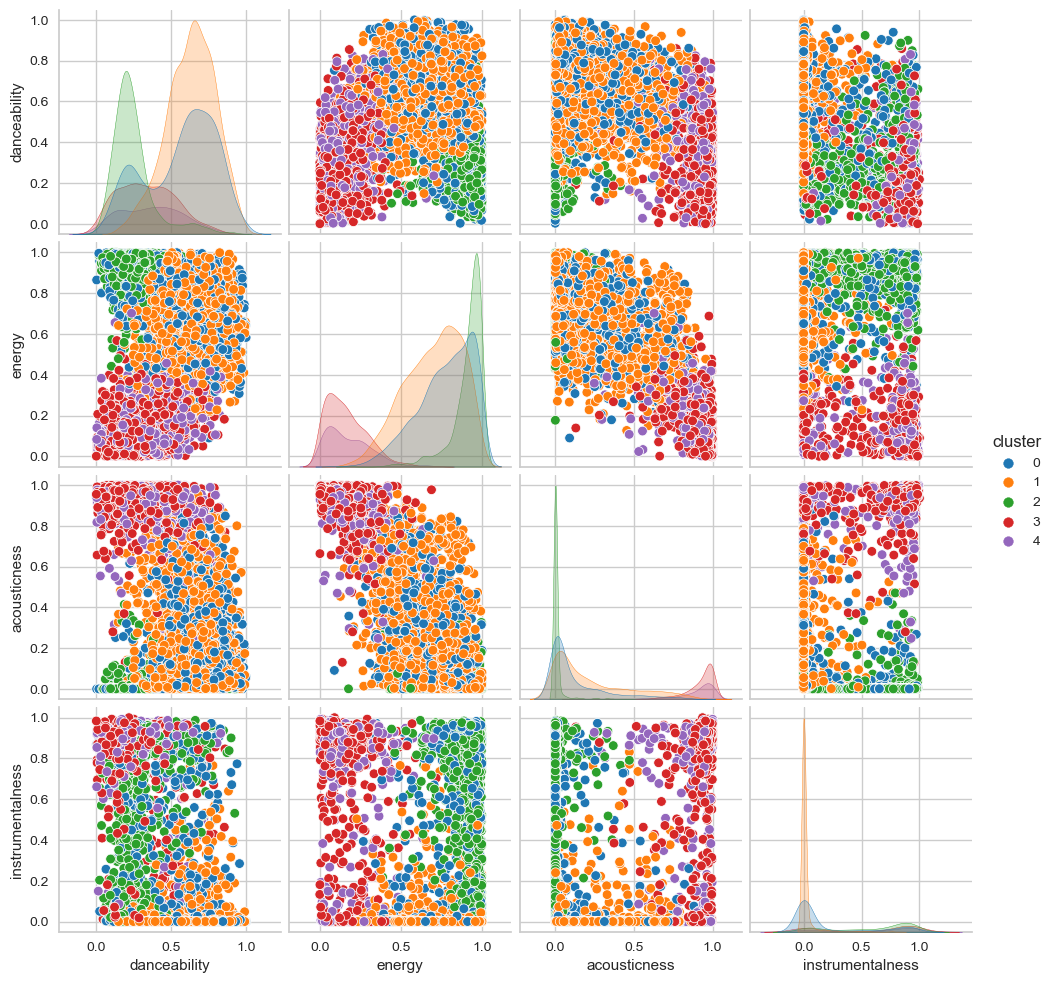

In [14]:
# Visualize the clusters separately
df3_minmax_test.columns
df3_minmax_test1  =df3_minmax_test.loc[:, ['danceability', 'energy', 'acousticness', 'instrumentalness', 'cluster']]
df3_minmax_test2  =df3_minmax_test.loc[:, ['loudness', 'speechiness', 'liveness', 'valence', 'tempo', 'cluster']]

sns.pairplot(df3_minmax_test1, hue="cluster", palette="tab10")

These four features seems to distinguish data well. 

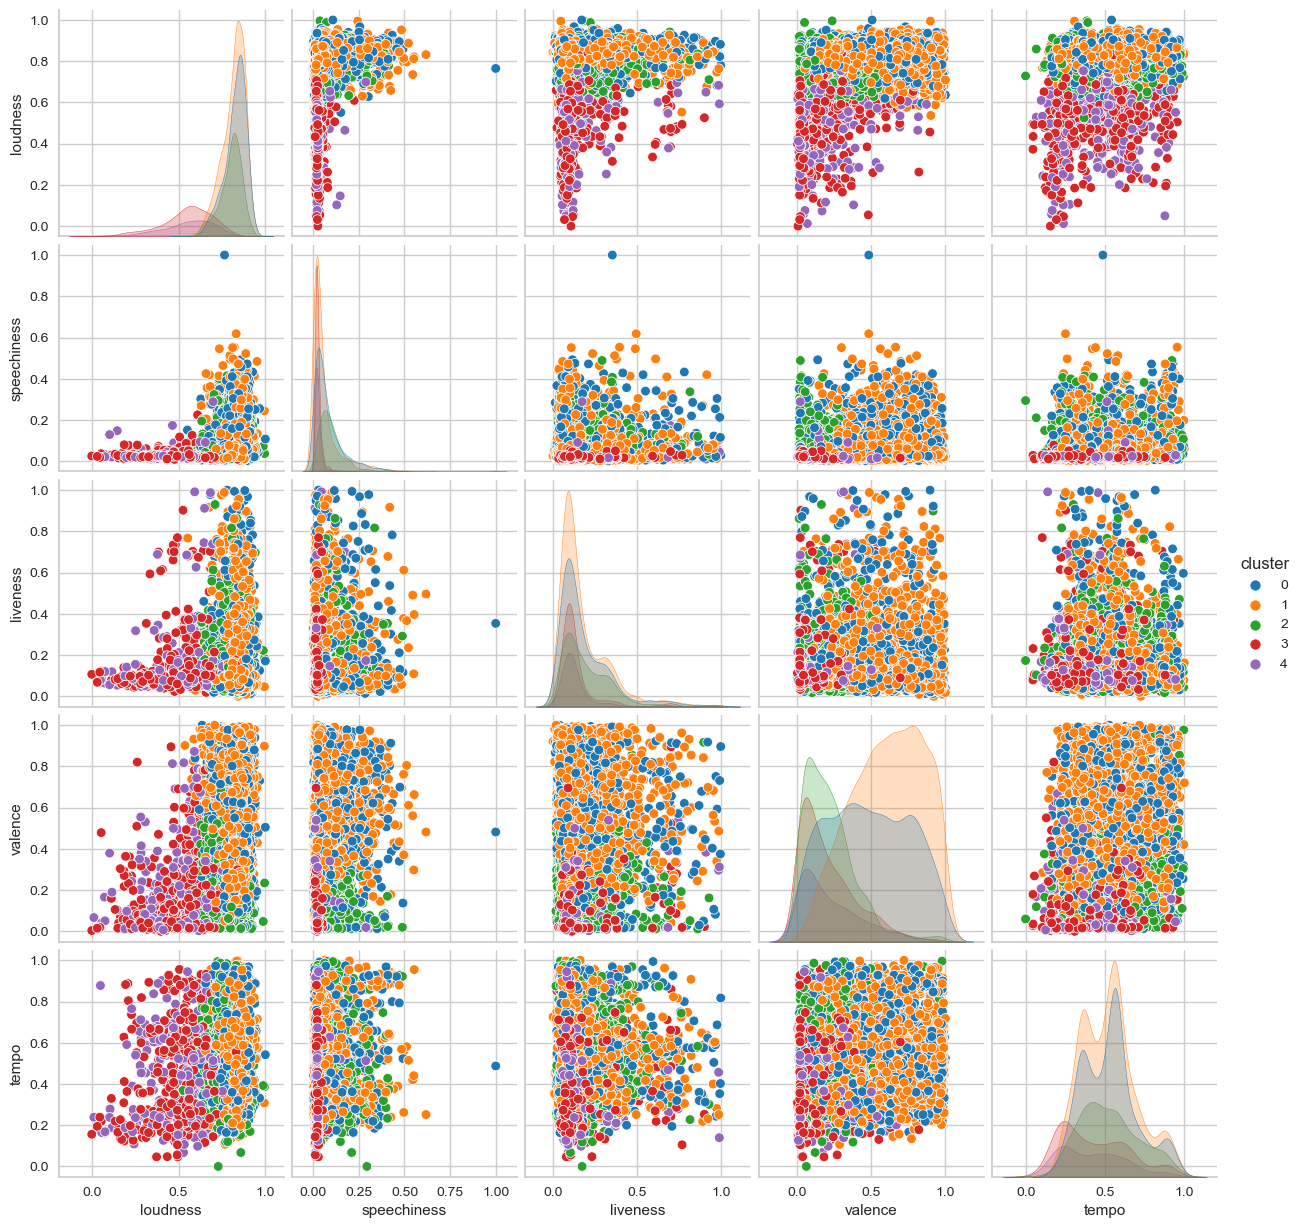

In [15]:
sns.pairplot(df3_minmax_test2, hue="cluster", palette="tab10")

These features do not seem a good job of distinguishing the data points. 

### Feature selection using PCA

In [16]:
# Create a PCA object
pca_variance = PCA(n_components=0.95)

# Fit the PCA object to the scaled features dataframe and transform it
pca_variance_df = pca_variance.fit_transform(df3_minmax_test)

# The dataframe now contains the principal components of the scaled features dataframe
pca_variance_df

# Initialise the model
my_kmeans = KMeans(n_clusters= 5, # you always choose the number of k here
                   n_init="auto",
                   random_state = 123)

# Fit the model to the data
my_kmeans.fit(pca_variance_df)

# Obtain the cluster output
clusters = my_kmeans.labels_

# Attach the cluster output to our clusters_df DataFrame
df3_minmax_test["PCA - 0.95"] = clusters

df3_minmax_test

danceability    energy       key  loudness  mode  \
id                                                                          
1n7JnwviZ7zf0LR1tcGFq7       0.659467  0.258985  1.000000  0.683418   0.0   
5QGM1U0eCYrQuwSJwTm5Zq       0.752039  0.398988  0.181818  0.694238   1.0   
0NLIFSZxPzQhCwnkn5PJYs       0.872162  0.729995  0.181818  0.729168   1.0   
3mXqOdlLE1k67WsAxryPFs       0.711263  0.050181  0.363636  0.574692   1.0   
7bSzjzjTkWT2CkIPPdp0eA       0.651752  0.118982  0.545455  0.537707   1.0   
...                               ...       ...       ...       ...   ...   
1aEhYlZtypmipA06SDJ4U3       0.156932  0.069381  0.272727  0.459386   1.0   
1Gfqe7TAKklmuZf6hxsH6h       0.141503  0.100982  0.545455  0.492546   1.0   
2XNwnFrdMDpismp0VUZ7cU       0.000000  0.000910  0.818182  0.031630   1.0   
7ucDwgMtE3YJtEfTbuRhy0       0.080890  0.020780  0.363636  0.327074   1.0   
7E1ErYYCn0lYjHODZ1qGuB       0.324443  0.048681  0.454545  0.433636   1.0   

                         speechiness  acousticness  instrumentalness  \
id                                                                     
1n7JnwviZ7zf0LR1tcGFq7      0.053496      0.696787          0.000060   
5QGM1U0eCYrQuwSJwTm5Zq      0.013402      0.217871          0.000002   
0NLIFSZxPzQhCwnkn5PJYs      0.362296      0.454819          0.000064   
3mXqOdlLE1k67WsAxryPFs      0.027362      0.882530          0.000041   
7bSzjzjTkWT2CkIPPdp0eA      0.017199      0.919679          0.000348   
...                              ...           ...               ...   
1aEhYlZtypmipA06SDJ4U3      0.027585      0.920683          0.725888   
1Gfqe7TAKklmuZf6hxsH6h      0.024123      0.858434          0.432487   
2XNwnFrdMDpismp0VUZ7cU      0.023230      0.954819          0.983756   
7ucDwgMtE3YJtEfTbuRhy0      0.021555      0.886546          0.512690   
7E1ErYYCn0lYjHODZ1qGuB      0.010833      0.786145          0.491371   

                         liveness   valence     tempo  cluster  PCA - 0.95  
id                                                                          
1n7JnwviZ7zf0LR1tcGFq7   0.987706  0.296665  0.456665        4           1  
5QGM1U0eCYrQuwSJwTm5Zq   0.098453  0.697535  0.555779        1           2  
0NLIFSZxPzQhCwnkn5PJYs   0.115869  0.917133  0.343930        1           2  
3mXqOdlLE1k67WsAxryPFs   0.384284  0.522478  0.432506        3           1  
7bSzjzjTkWT2CkIPPdp0eA   0.095380  0.396105  0.528079        3           1  
...                           ...       ...       ...      ...         ...  
1aEhYlZtypmipA06SDJ4U3   0.074070  0.047545  0.304779        3           1  
1Gfqe7TAKklmuZf6hxsH6h   0.059932  0.016470  0.272523        3           1  
2XNwnFrdMDpismp0VUZ7cU   0.067923  0.015330  0.194376        3           1  
7ucDwgMtE3YJtEfTbuRhy0   0.102551  0.040916  0.164202        3           1  
7E1ErYYCn0lYjHODZ1qGuB   0.279787  0.241765  0.143998        3           1  

[5122 rows x 13 columns]

Observe that clusters created using PCA show similar pattern to our KMeans clusters. Showing that most information is preserved.

#### PCA to check reletive contribution of features

In [17]:
# Drop the columns and run the PCA again
df3_minmax_test2 = df3_minmax_test.drop(columns=['cluster', 'PCA - 0.95'], axis=1)

# Assuming df3_minmax_test2 is your scaled features dataframe
pca_variance = PCA(n_components=0.95)

# Fit the PCA object to the scaled features dataframe and transform it
pca_variance_df = pca_variance.fit_transform(df3_minmax_test2)

# Get the loadings of each principal component
loadings = pca_variance.components_

# Calculate the contributions of each original feature to each principal component
contributions = pd.DataFrame(index=df3_minmax_test2.columns)

for i in range(pca_variance.n_components_):
    contribution_i = loadings[i, :] * (pca_variance.explained_variance_ratio_[i] ** 0.5)
    contributions[f'PC_{i+1}'] = contribution_i

# Print or visualize the DataFrame
pd.DataFrame(contributions)

PC_1      PC_2      PC_3      PC_4      PC_5      PC_6  \
danceability     -0.141786 -0.018445 -0.145324 -0.009498  0.079714 -0.038151   
energy           -0.213625 -0.053883  0.185191 -0.007217  0.010153  0.002835   
key              -0.036622  0.091124  0.013083  0.324416  0.016581 -0.001114   
loudness         -0.115993 -0.027323  0.032489 -0.002213 -0.005470  0.001764   
mode              0.133547 -0.477993  0.010980  0.062840  0.007165 -0.002836   
speechiness      -0.018823 -0.001102  0.016863  0.000719 -0.004214 -0.002956   
acousticness      0.276062  0.062073 -0.229004  0.012009 -0.003694  0.030585   
instrumentalness  0.273114  0.084209  0.221462 -0.018204  0.157145 -0.008468   
liveness         -0.019377 -0.003109  0.016083  0.004010 -0.013136  0.011930   
valence          -0.171626 -0.053570 -0.152796 -0.011949  0.170675  0.015387   
tempo            -0.041197 -0.011335  0.027233 -0.000988  0.010999  0.183884   

                      PC_7  
danceability     -0.048031  
energy            0.040499  
key              -0.002072  
loudness          0.007660  
mode             -0.002914  
speechiness       0.003859  
acousticness      0.042606  
instrumentalness -0.003203  
liveness          0.136747  
valence           0.037009  
tempo            -0.029862

For first component *PC_1*, "acousticness" (0.276062) and "instrumentalness" (0.273114) show the highest positive loadings and "danceability", "energy" (-0.213625) and "valence" (-0.171626) show negative loadings.

**Note** We exclude *valence* from the first step as it needn’t drive broad categorizations.

### First round of clustering
The above pairplot indicates that the following four columns can be very helpful in creating distinct clusters: 'danceability', 'energy', and 'acousticness', 'instrumentalness'. We use them for the first layer of clustering.

In [18]:
# Let's list the distinctive four columns
col_list = ['danceability', 'energy', 'acousticness', 'instrumentalness']#, 'valence']

# Scale the data
df3_new = df3.loc[:, col_list]
print(df3_new.columns)
scaler = MinMaxScaler().set_output(transform="pandas")
df3_minmax = scaler.fit_transform(df3_new)
df3_minmax

Index(['danceability', 'energy', 'acousticness', 'instrumentalness'], dtype='object')


danceability    energy  acousticness  \
id                                                              
1n7JnwviZ7zf0LR1tcGFq7       0.659467  0.258985      0.696787   
5QGM1U0eCYrQuwSJwTm5Zq       0.752039  0.398988      0.217871   
0NLIFSZxPzQhCwnkn5PJYs       0.872162  0.729995      0.454819   
3mXqOdlLE1k67WsAxryPFs       0.711263  0.050181      0.882530   
7bSzjzjTkWT2CkIPPdp0eA       0.651752  0.118982      0.919679   
...                               ...       ...           ...   
1aEhYlZtypmipA06SDJ4U3       0.156932  0.069381      0.920683   
1Gfqe7TAKklmuZf6hxsH6h       0.141503  0.100982      0.858434   
2XNwnFrdMDpismp0VUZ7cU       0.000000  0.000910      0.954819   
7ucDwgMtE3YJtEfTbuRhy0       0.080890  0.020780      0.886546   
7E1ErYYCn0lYjHODZ1qGuB       0.324443  0.048681      0.786145   

                         instrumentalness  
id                                         
1n7JnwviZ7zf0LR1tcGFq7           0.000060  
5QGM1U0eCYrQuwSJwTm5Zq           0.000002  
0NLIFSZxPzQhCwnkn5PJYs           0.000064  
3mXqOdlLE1k67WsAxryPFs           0.000041  
7bSzjzjTkWT2CkIPPdp0eA           0.000348  
...                                   ...  
1aEhYlZtypmipA06SDJ4U3           0.725888  
1Gfqe7TAKklmuZf6hxsH6h           0.432487  
2XNwnFrdMDpismp0VUZ7cU           0.983756  
7ucDwgMtE3YJtEfTbuRhy0           0.512690  
7E1ErYYCn0lYjHODZ1qGuB           0.491371  

[5122 rows x 4 columns]

In [19]:
# Create a PCA object
pca_variance = PCA(n_components=0.95)

# Fit the PCA object to the scaled features dataframe and transform it
pca_variance_df = pca_variance.fit_transform(df3_minmax)

# The dataframe now contains the principal components of the scaled features dataframe
pca_variance_df

array([[ 0.30594787, -0.5658172 ,  0.01932218],
       [-0.10485176, -0.35497641,  0.14465958],
       [-0.14103344, -0.3844797 ,  0.1941553 ],
       ...,
       [ 1.2384054 ,  0.22848097, -0.14520996],
       [ 0.93086999, -0.12009633, -0.27221347],
       [ 0.78811607, -0.17880822, -0.05597782]])

In [20]:
# Initialise the model
my_kmeans = KMeans(n_clusters= 5, # you always choose the number of k here
                   n_init="auto",
                   random_state = 123)

# Fit the model to the data
my_kmeans.fit(pca_variance_df)

# Obtain the cluster output
clusters = my_kmeans.labels_

# Attach the cluster output to our clusters_df DataFrame
df3_minmax["PCA - 0.95"] = clusters

df3_minmax

danceability    energy  acousticness  \
id                                                              
1n7JnwviZ7zf0LR1tcGFq7       0.659467  0.258985      0.696787   
5QGM1U0eCYrQuwSJwTm5Zq       0.752039  0.398988      0.217871   
0NLIFSZxPzQhCwnkn5PJYs       0.872162  0.729995      0.454819   
3mXqOdlLE1k67WsAxryPFs       0.711263  0.050181      0.882530   
7bSzjzjTkWT2CkIPPdp0eA       0.651752  0.118982      0.919679   
...                               ...       ...           ...   
1aEhYlZtypmipA06SDJ4U3       0.156932  0.069381      0.920683   
1Gfqe7TAKklmuZf6hxsH6h       0.141503  0.100982      0.858434   
2XNwnFrdMDpismp0VUZ7cU       0.000000  0.000910      0.954819   
7ucDwgMtE3YJtEfTbuRhy0       0.080890  0.020780      0.886546   
7E1ErYYCn0lYjHODZ1qGuB       0.324443  0.048681      0.786145   

                         instrumentalness  PCA - 0.95  
id                                                     
1n7JnwviZ7zf0LR1tcGFq7           0.000060           3  
5QGM1U0eCYrQuwSJwTm5Zq           0.000002           0  
0NLIFSZxPzQhCwnkn5PJYs           0.000064           0  
3mXqOdlLE1k67WsAxryPFs           0.000041           3  
7bSzjzjTkWT2CkIPPdp0eA           0.000348           3  
...                                   ...         ...  
1aEhYlZtypmipA06SDJ4U3           0.725888           1  
1Gfqe7TAKklmuZf6hxsH6h           0.432487           1  
2XNwnFrdMDpismp0VUZ7cU           0.983756           1  
7ucDwgMtE3YJtEfTbuRhy0           0.512690           1  
7E1ErYYCn0lYjHODZ1qGuB           0.491371           1  

[5122 rows x 5 columns]

### Elbow and Silhouette score methods to select number of clusters

In [21]:
wcss = [] 
sil_scores = []
for i in range(2, 20): 
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = random_seed)
    kmeans.fit(df3_minmax) 
    wcss.append(kmeans.inertia_)
    # Calculate the silhouette score
    score = silhouette_score(df3_minmax, kmeans.labels_)
    # Append the silhouette score to the list
    sil_scores.append(score)

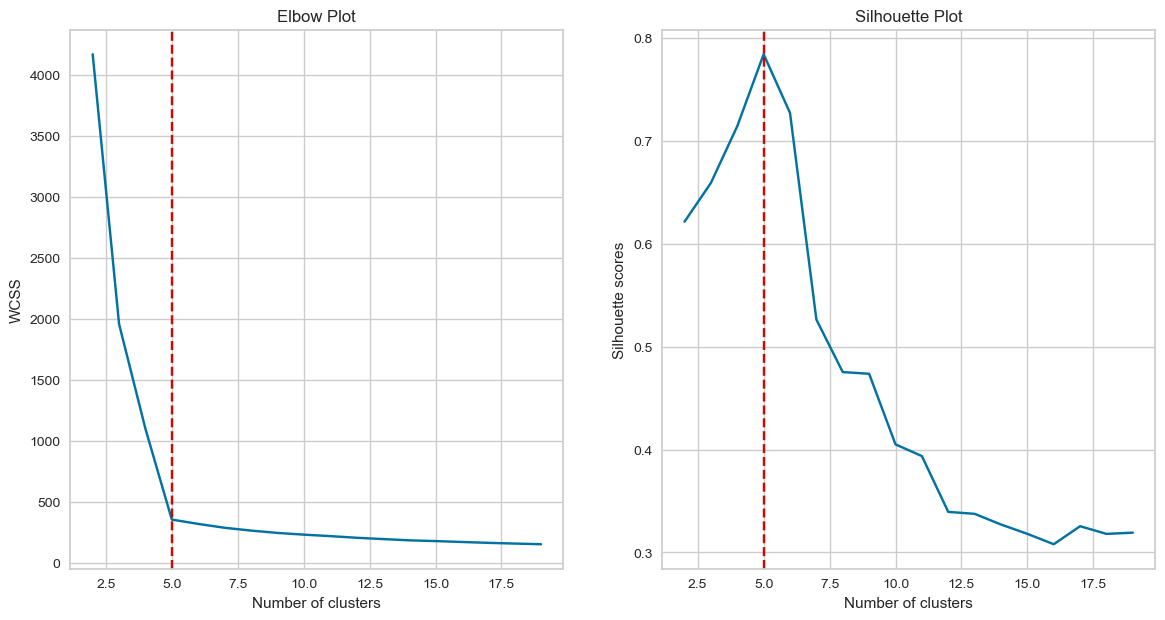

In [22]:
# Plot the Elbow and Silhouette scores plots
fig, axs = plt.subplots(1, 2, figsize=(14,7))
# fig.suptitle('Elbow and Silhouette plots')
axs[0].plot(range(2, 20), wcss)
axs[0].set_title('Elbow Plot')
axs[0].set_xlabel('Number of clusters')
axs[0].axvline(x=5, color='r', linestyle='--', label='Reference Line at x=5')
axs[0].set_ylabel('WCSS') 

axs[1].plot(range(2, 20), sil_scores)
axs[1].set_title('Silhouette Plot')
axs[1].set_xlabel('Number of clusters')
axs[1].axvline(x=5, color='r', linestyle='--', label='Reference Line at x=5')
axs[1].set_ylabel('Silhouette scores')
plt.show()

At n_clusters = 5, the inertia scores observe a sharp decline, the curve flattens afterward. 5 looks to be right amount of clusters for clustering. 

At n_clusters = 5, the Silhouette score also peaks. 

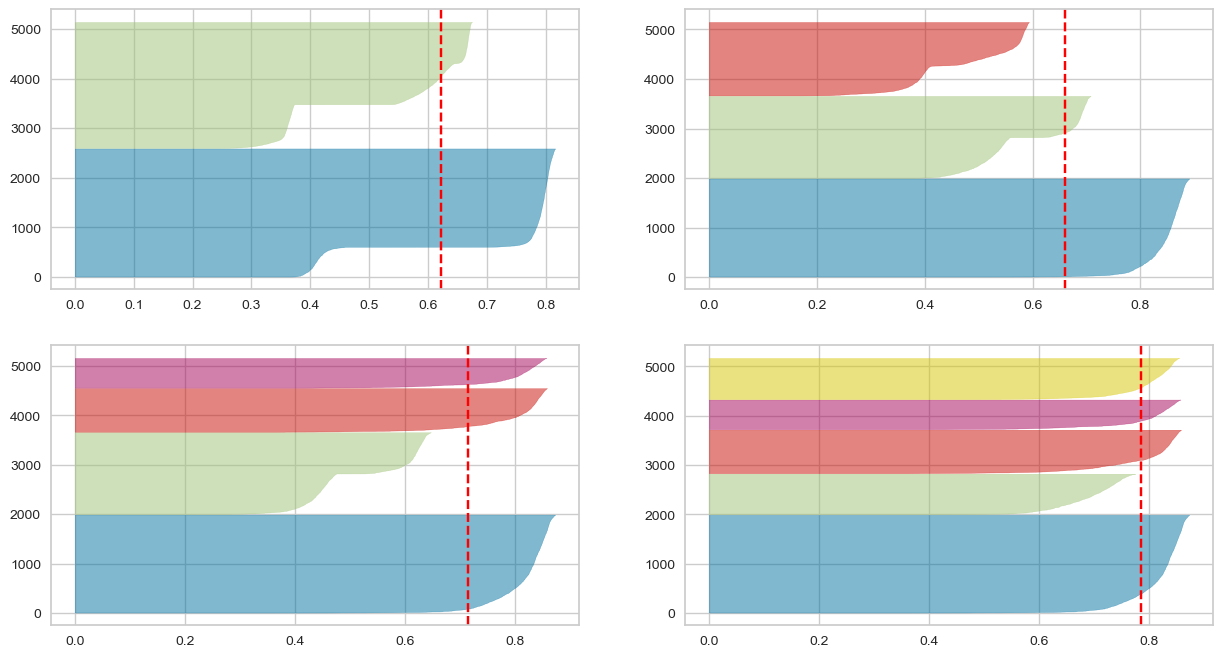

In [23]:
# Another approach at Silhouette plots
# source: https://vitalflux.com/kmeans-silhouette-score-explained-with-python-example/ 
fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [2, 3, 4, 5]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=random_seed)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(df3_minmax)

The plots for the n_clusters = 2, 3 and 5 look optimal as the silhouette scores for each cluster are above average silhouette scores. For n_cluster=5 (bottom right), the fluctuation in size is relatively smaller and the thickness is more uniform than the plot with n_cluster as 2/3 (top). Thus, I select the optimal number of clusters as 5.

### Let's make 5 clusters

In [24]:
# initialize the model
my_kmeans = KMeans(n_clusters = 5, n_init = 'auto', random_state = random_seed)

# fit the model to the data
my_kmeans.fit(df3_minmax)

# obtain the cluster output
similarity_minmax = my_kmeans.labels_

# attach the cluster output to our original DataFrame
df3["cluster_main"] = similarity_minmax
df3_new["cluster_main"] = similarity_minmax
df3_minmax["cluster_main"] = similarity_minmax

In [25]:
# Check feature means by clusters
df3_minmax.groupby(by="cluster_main").mean()

danceability    energy  acousticness  instrumentalness  \
cluster_main                                                           
0                 0.708787  0.720105      0.144665          0.016233   
1                 0.516596  0.379595      0.738439          0.032983   
2                 0.273605  0.888100      0.017734          0.805505   
3                 0.297609  0.139511      0.934228          0.874046   
4                 0.340981  0.889167      0.027899          0.073288   

              PCA - 0.95  
cluster_main              
0                    0.0  
1                    3.0  
2                    2.0  
3                    1.0  
4                    4.0

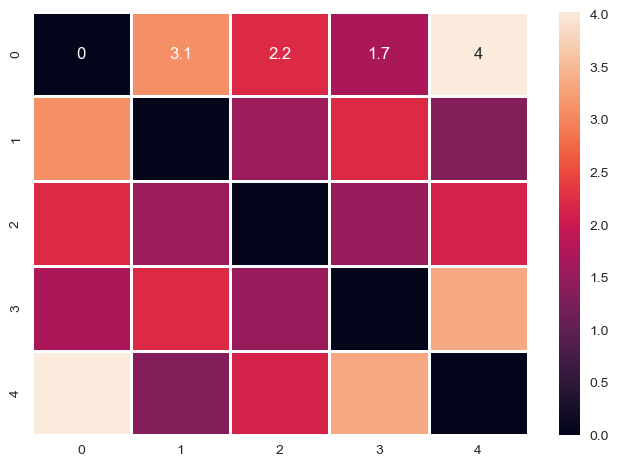

In [26]:
# Find the coordinates of each centroid using the cluster_centers_ attribute
centroids = my_kmeans.cluster_centers_

# Calculate the euclidean distance between the centroids
centroid_distances = pairwise_distances(centroids)

# Plot distances on heatmap
sns.heatmap(centroid_distances,
            annot=True,
            linewidths=1);

Cluster centroids are relatively distinctly placed.

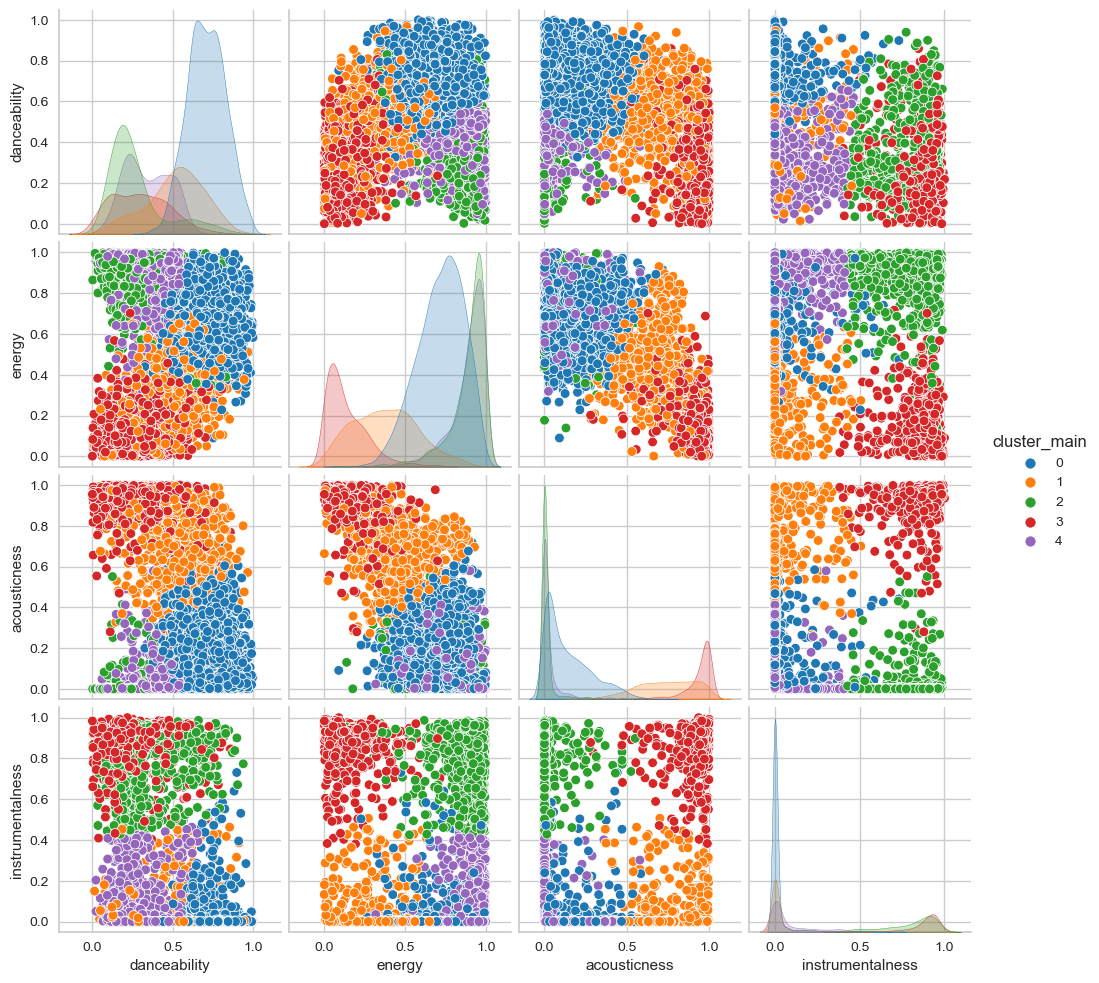

In [27]:
df3_minmax = df3_minmax.drop(columns="PCA - 0.95", axis=1)
sns.pairplot(df3_minmax, hue="cluster_main", palette="tab10")

Clustering seems to work. The four features are able to distinguish clusters well. :) 

In [28]:
# Save cluster IDs for later
df3_minmax_cluster_main = df3_minmax["cluster_main"].reset_index()
df3_minmax_cluster_main.cluster_main.value_counts()

cluster_main
0    1982
2     882
4     833
1     824
3     601
Name: count, dtype: int64

### Second round of clustering (subclusters)
We will use all columns for this round

In [29]:
# Choose columns for clustering
coarse_metrics = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'cluster_main']
df3_new_new = df3.loc[:, coarse_metrics]
print(df3_new_new.columns)

# Chose columns for scaling
scaler = MinMaxScaler().set_output(transform="pandas")
df3_minmax_new = scaler.fit_transform(df3_new_new.loc[:, coarse_metrics])
df3_minmax_new

df_coarse = df3_minmax_new.loc[:, df3_minmax_new.columns.isin(coarse_metrics)].copy()
df_coarse.describe()

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'cluster_main'],
      dtype='object')


danceability       energy          key     loudness         mode  \
count   5122.000000  5122.000000  5122.000000  5122.000000  5122.000000   
mean       0.494867     0.653624     0.479944     0.765904     0.646622   
std        0.240208     0.289542     0.324408     0.137206     0.478065   
min        0.000000     0.000000     0.000000     0.000000     0.000000   
25%        0.271545     0.476989     0.181818     0.722032     0.000000   
50%        0.527221     0.738995     0.454545     0.809795     1.000000   
75%        0.692528     0.894998     0.727273     0.854917     1.000000   
max        1.000000     1.000000     1.000000     1.000000     1.000000   

       speechiness  acousticness  instrumentalness     liveness      valence  \
count  5122.000000   5122.000000       5122.000000  5122.000000  5122.000000   
mean      0.067223      0.291986          0.264771     0.179005     0.437016   
std       0.078812      0.358173          0.377647     0.153328     0.287921   
min       0.000000      0.000000          0.000000     0.000000     0.000000   
25%       0.018120      0.002292          0.000001     0.083624     0.180651   
50%       0.036799      0.096285          0.002279     0.116894     0.407499   
75%       0.084878      0.570281          0.668020     0.231636     0.678890   
max       1.000000      1.000000          1.000000     1.000000     1.000000   

             tempo  cluster_main  
count  5122.000000   5122.000000  
mean      0.507971      0.376952  
std       0.186406      0.373728  
min       0.000000      0.000000  
25%       0.359747      0.000000  
50%       0.514154      0.250000  
75%       0.611285      0.750000  
max       1.000000      1.000000

In [30]:
df_coarse.cluster_main.value_counts()

cluster_main
0.00    1982
0.50     882
1.00     833
0.25     824
0.75     601
Name: count, dtype: int64

In [31]:
cluster_dataframes = {}  # Create an empty dictionary to store DataFrames

df_unused = df3_minmax_new.loc[:, ["speechiness", "liveness", "valence", "tempo", "cluster_main"]].copy()

for cluster_value in df_unused["cluster_main"].unique():
    df_cluster = df_unused[df_unused["cluster_main"] == cluster_value].copy()
    
    # Drop the 'cluster_main' column from the DataFrame
    df_cluster.drop(columns=["cluster_main"], inplace=True)
    
    cluster_dataframes[cluster_value] = df_cluster

In [32]:
cluster_dataframes[1]

speechiness  liveness   valence     tempo
id                                                                
7CjSjWTdVPD0ov82Qz55Xb      0.103194  0.575863  0.912989  0.294011
2PIC7KxAgHGYCGuGqcorw7      0.014072  0.167094  0.632277  0.609700
5mt3HpjZuJNpqg1k415CnR      0.008041  0.115869  0.726538  0.738083
3VsYJCWecqxdwAN2Xu3cL5      0.025687  0.122016  0.339134  0.650730
1CDX9A7Gw2PJOVNij6z0Rx      0.018204  0.024690  0.607417  0.765195
...                              ...       ...       ...       ...
4gQ8q2cDKHoaQsLLVfp9NH      0.038865  0.718267  0.253159  0.822827
51fegUPIH02heRh9fkkLwE      0.067568  0.054503  0.208618  0.897202
2yK4879j9Q1XnJio6ETqJV      0.253965  0.066694  0.500725  0.552758
3yJdWQxmFO7nvNjEybCeYE      0.132231  0.653724  0.336027  0.725186
5J0TvJIdYrybgk6SINgieR      0.051932  0.603524  0.341206  0.588002

[833 rows x 4 columns]

In [33]:
wcss_dict = {}
sil_dict = {}

for cluster_value, df_cluster in cluster_dataframes.items():
    wcss = [] 
    sil_scores = []
    
    for num_clusters in range(2, 20): 
        kmeans = KMeans(n_clusters=num_clusters, init='k-means++', random_state=random_seed)
        kmeans.fit(df_cluster) 
        wcss.append(kmeans.inertia_)
        
        # Calculate the silhouette score
        score = silhouette_score(df_cluster, kmeans.labels_)
        sil_scores.append(score)
    
    wcss_dict[cluster_value] = wcss
    sil_dict[cluster_value] = sil_scores

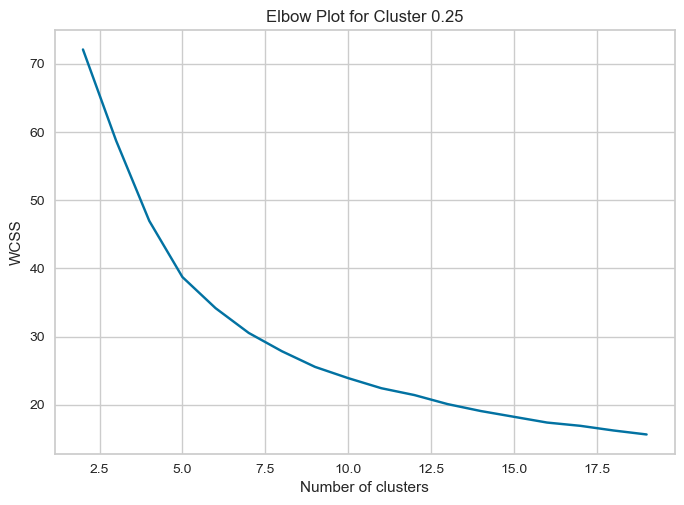

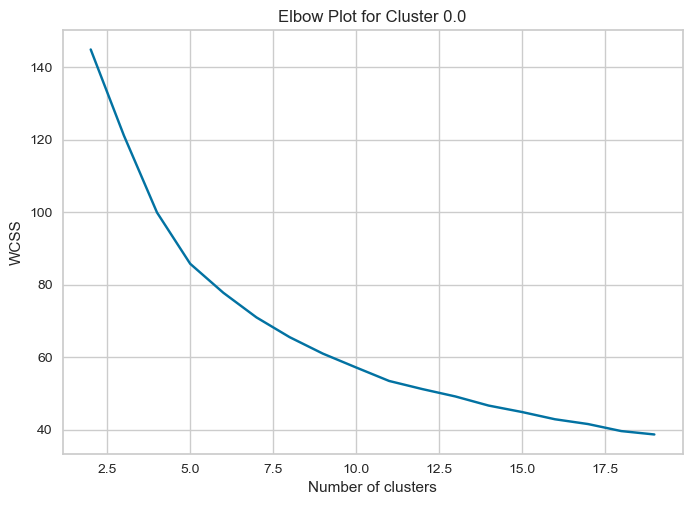

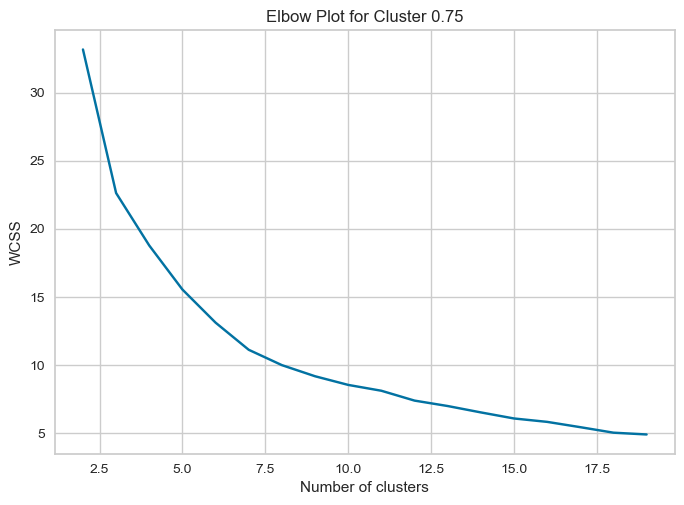

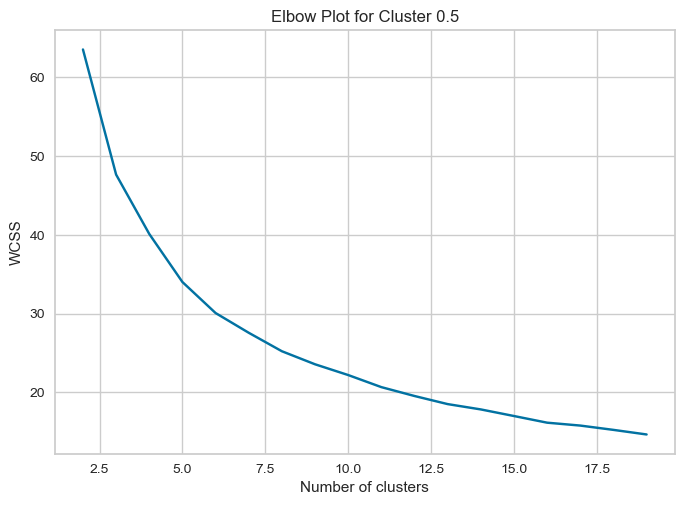

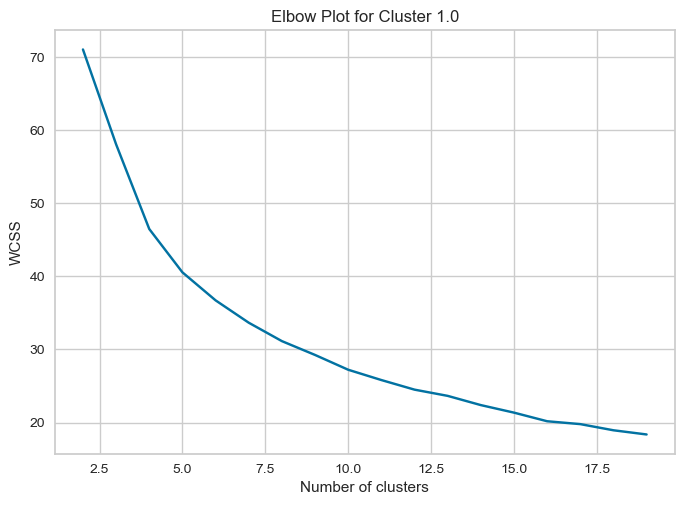

In [34]:
for cluster_value, wcss_values in wcss_dict.items():
    plt.plot(range(2, 20), wcss_values)  # Assuming 30 as the upper limit for the number of clusters
    plt.title(f'Elbow Plot for Cluster {cluster_value}')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

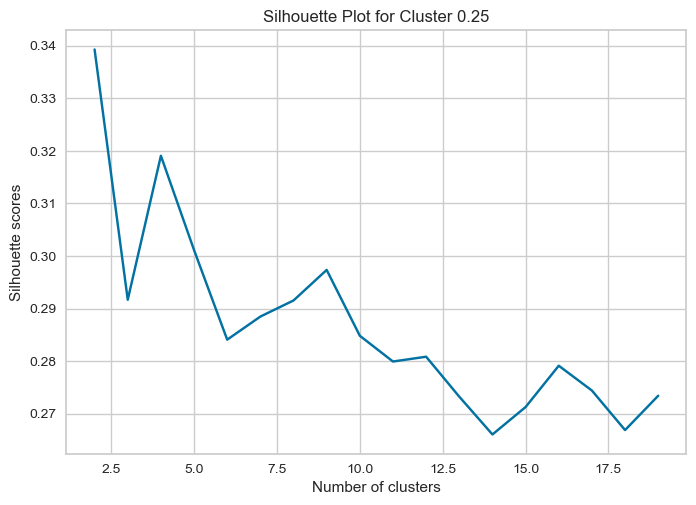

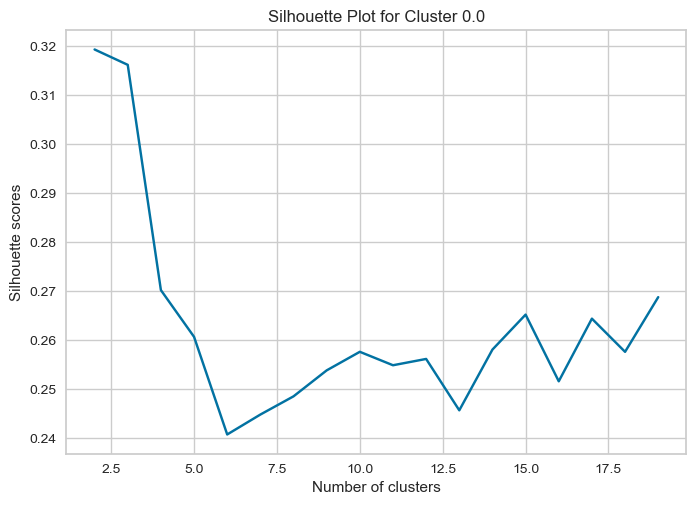

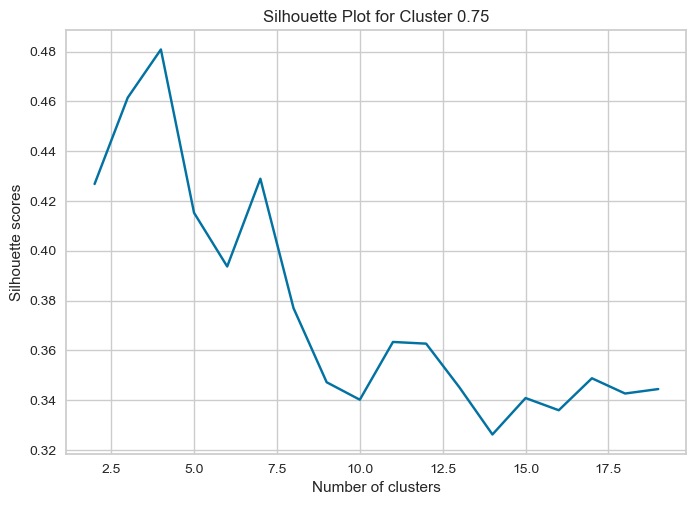

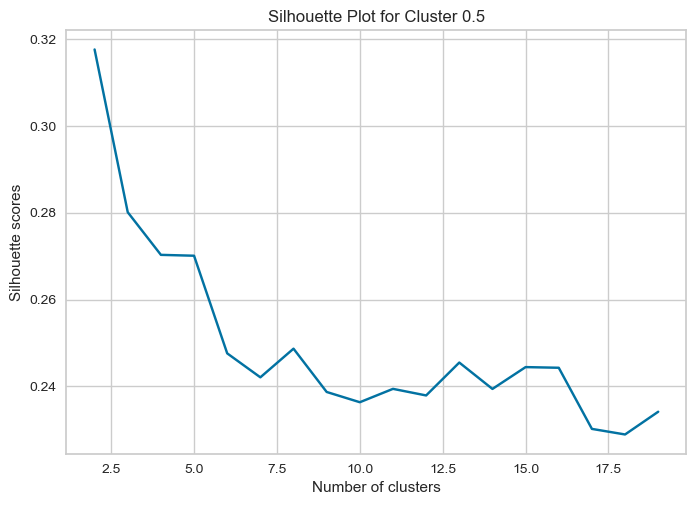

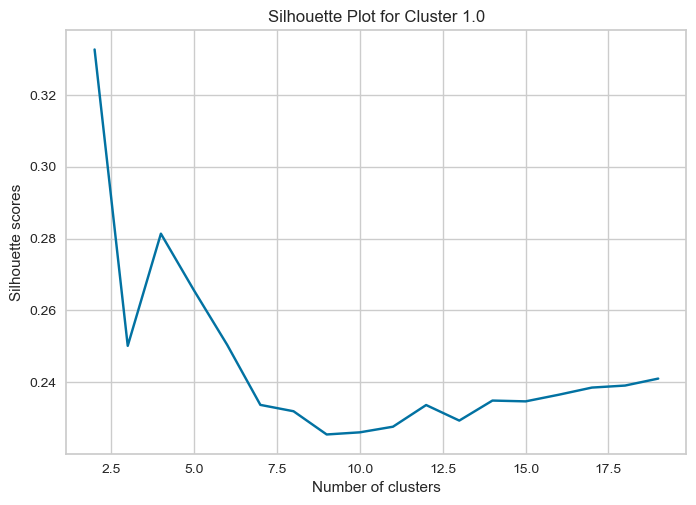

In [35]:
for cluster_value, sil_values in sil_dict.items():
    plt.plot(range(2, 20), sil_values)  # Assuming 30 as the upper limit for the number of clusters
    plt.title(f'Silhouette Plot for Cluster {cluster_value}')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette scores')
    plt.show()

In [36]:
df_cluster=df_cluster.loc[:, ["speechiness",	"liveness",	"valence",	"tempo", ]]

In [37]:
for cluster_value, df_cluster in cluster_dataframes.items():
    my_kmeans = KMeans(n_clusters=4, n_init='auto', random_state=random_seed)
    my_kmeans.fit(df_cluster)
    
    # obtain the cluster output
    similarity_minmax = my_kmeans.labels_
    
    # attach the cluster output to the original DataFrame
    df_cluster["sub_cluster"] = similarity_minmax

In [38]:
cluster_dataframes[0]

speechiness  liveness   valence     tempo  \
id                                                                   
5QGM1U0eCYrQuwSJwTm5Zq      0.013402  0.098453  0.697535  0.555779   
0NLIFSZxPzQhCwnkn5PJYs      0.362296  0.115869  0.917133  0.343930   
1wL2dk42Cxu4zCJs4SvFsZ      0.019433  0.145579  0.643671  0.859909   
5iKuMCDh634YGrg2HrhtHp      0.017422  0.131237  0.534908  0.386495   
1OzHkIzGMj4S3rWwF8TBjc      0.048247  0.453949  0.824943  0.305604   
...                              ...       ...       ...       ...   
54PHTV8sTaZqYDLsLAmLDG      0.075385  0.261346  0.380568  0.671414   
0Ek4F4tQB91pf5ybGQkBn0      0.075274  0.399652  0.430288  0.414918   
6nvtHB8cv559sNsUDhoFhn      0.064105  0.656797  0.684069  0.494606   
07LmMX6JMjGRZEaA8T04xr      0.029149  0.128163  0.674746  0.602690   
0Va3lL2FGZZMU5Myuj9dWp      0.059862  0.081856  0.742076  0.366473   

                         sub_cluster  
id                                    
5QGM1U0eCYrQuwSJwTm5Zq             1  
0NLIFSZxPzQhCwnkn5PJYs             2  
1wL2dk42Cxu4zCJs4SvFsZ             1  
5iKuMCDh634YGrg2HrhtHp             2  
1OzHkIzGMj4S3rWwF8TBjc             0  
...                              ...  
54PHTV8sTaZqYDLsLAmLDG             3  
0Ek4F4tQB91pf5ybGQkBn0             0  
6nvtHB8cv559sNsUDhoFhn             0  
07LmMX6JMjGRZEaA8T04xr             1  
0Va3lL2FGZZMU5Myuj9dWp             2  

[1982 rows x 5 columns]

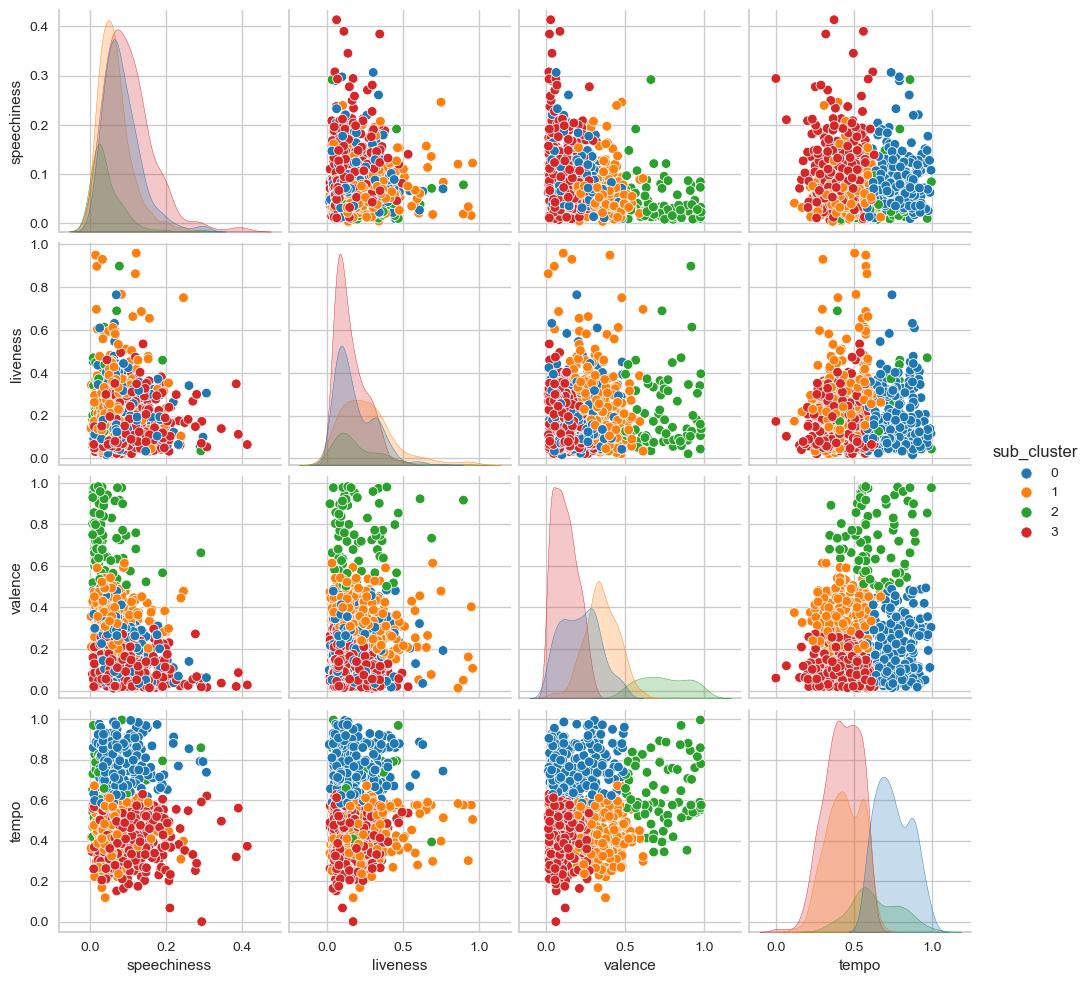

In [39]:
df_test = pd.DataFrame(cluster_dataframes[0.5])
df_test = df_test.loc[:, ["speechiness", "liveness", "valence", "tempo", "sub_cluster"]]
df_test.columns
# df_test= df_test.drop(columns=['danceability', 'energy', 'key', 'mode', 'acousticness', 'instrumentalness', 'loudness'])
sns.pairplot(df_test, hue="sub_cluster", palette="tab10")

In [40]:
df3_new.describe()

danceability       energy  acousticness  instrumentalness  cluster_main
count   5122.000000  5122.000000   5122.000000       5122.000000   5122.000000
mean       0.508643     0.653631      0.290818          0.260800      1.507809
std        0.217964     0.289537      0.356740          0.371982      1.494910
min        0.059600     0.000020      0.000000          0.000000      0.000000
25%        0.306000     0.477000      0.002282          0.000001      0.000000
50%        0.538000     0.739000      0.095900          0.002245      1.000000
75%        0.688000     0.895000      0.568000          0.658000      3.000000
max        0.967000     1.000000      0.996000          0.985000      4.000000

In [41]:
df2.columns

Index(['name', 'artist', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'type', 'duration_ms', 'time_signature', 'html'],
      dtype='object')

In [42]:
df2_titles = df2[['name', 'artist']].reset_index()
df2_titles

id  \
0     1n7JnwviZ7zf0LR1tcGFq7    
1     5QGM1U0eCYrQuwSJwTm5Zq    
2     0NLIFSZxPzQhCwnkn5PJYs    
3     3mXqOdlLE1k67WsAxryPFs    
4     7bSzjzjTkWT2CkIPPdp0eA    
...                       ...   
5166  1aEhYlZtypmipA06SDJ4U3    
5167  1Gfqe7TAKklmuZf6hxsH6h    
5168  2XNwnFrdMDpismp0VUZ7cU    
5169  7ucDwgMtE3YJtEfTbuRhy0    
5170  7E1ErYYCn0lYjHODZ1qGuB    

                                                   name  \
0                           Se Eu Quiser Falar Com Deus   
1                                      Saudade De Bahia   
2                              Canta Canta, Minha Gente   
3                                         Mulher Eu Sei   
4                                           Rosa Morena   
...                                                 ...   
5166  1812 Festival Overture, Op. 49: 1812 Overture,...   
5167  Winter Fragments pour ensemble instrumental, s...   
5168  Schoenberg: 5 Orchestral Pieces, Op. 16: No. 3...   
5169  Serenade For Strings In E, Op.22, B. 52: 1. Mo...   
5170                               Ravel: Boléro, M. 81   

                        artist  
0                 Gilberto Gil  
1         Antônio Carlos Jobim  
2             Martinho Da Vila  
3                  Chico César  
4                  Kurt Elling  
...                        ...  
5166  Pyotr Ilyich Tchaikovsky  
5167            Tristan Murail  
5168         Arnold Schoenberg  
5169            Antonín Dvořák  
5170             Maurice Ravel  

[5171 rows x 3 columns]

In [43]:
cluster_dataframes[1]

speechiness  liveness   valence     tempo  \
id                                                                   
7CjSjWTdVPD0ov82Qz55Xb      0.103194  0.575863  0.912989  0.294011   
2PIC7KxAgHGYCGuGqcorw7      0.014072  0.167094  0.632277  0.609700   
5mt3HpjZuJNpqg1k415CnR      0.008041  0.115869  0.726538  0.738083   
3VsYJCWecqxdwAN2Xu3cL5      0.025687  0.122016  0.339134  0.650730   
1CDX9A7Gw2PJOVNij6z0Rx      0.018204  0.024690  0.607417  0.765195   
...                              ...       ...       ...       ...   
4gQ8q2cDKHoaQsLLVfp9NH      0.038865  0.718267  0.253159  0.822827   
51fegUPIH02heRh9fkkLwE      0.067568  0.054503  0.208618  0.897202   
2yK4879j9Q1XnJio6ETqJV      0.253965  0.066694  0.500725  0.552758   
3yJdWQxmFO7nvNjEybCeYE      0.132231  0.653724  0.336027  0.725186   
5J0TvJIdYrybgk6SINgieR      0.051932  0.603524  0.341206  0.588002   

                         sub_cluster  
id                                    
7CjSjWTdVPD0ov82Qz55Xb             3  
2PIC7KxAgHGYCGuGqcorw7             3  
5mt3HpjZuJNpqg1k415CnR             3  
3VsYJCWecqxdwAN2Xu3cL5             1  
1CDX9A7Gw2PJOVNij6z0Rx             3  
...                              ...  
4gQ8q2cDKHoaQsLLVfp9NH             0  
51fegUPIH02heRh9fkkLwE             1  
2yK4879j9Q1XnJio6ETqJV             3  
3yJdWQxmFO7nvNjEybCeYE             0  
5J0TvJIdYrybgk6SINgieR             0  

[833 rows x 5 columns]

In [44]:
dataframes_list = list(cluster_dataframes.values())

# Concatenate the dataframes
final_df = pd.concat(dataframes_list).reset_index()
final_df

id  speechiness  liveness   valence     tempo  \
0     1n7JnwviZ7zf0LR1tcGFq7      0.053496  0.987706  0.296665  0.456665   
1     3mXqOdlLE1k67WsAxryPFs      0.027362  0.384284  0.522478  0.432506   
2     7bSzjzjTkWT2CkIPPdp0eA      0.017199  0.095380  0.396105  0.528079   
3     5pstSsK0G4q86gdyy1Spqh      0.047241  0.098453  0.417858  0.676409   
4     33u3dO0JWjerYpFN61J3ug      0.035627  0.103575  0.688212  0.342801   
...                       ...          ...       ...       ...       ...   
5117  4gQ8q2cDKHoaQsLLVfp9NH      0.038865  0.718267  0.253159  0.822827   
5118  51fegUPIH02heRh9fkkLwE      0.067568  0.054503  0.208618  0.897202   
5119  2yK4879j9Q1XnJio6ETqJV      0.253965  0.066694  0.500725  0.552758   
5120  3yJdWQxmFO7nvNjEybCeYE      0.132231  0.653724  0.336027  0.725186   
5121  5J0TvJIdYrybgk6SINgieR      0.051932  0.603524  0.341206  0.588002   

      sub_cluster  
0               3  
1               2  
2               1  
3               1  
4               2  
...           ...  
5117            0  
5118            1  
5119            3  
5120            0  
5121            0  

[5122 rows x 6 columns]

In [45]:
df_final = final_df.merge(df2_titles, how="left", on="id").merge(df3_minmax_cluster_main, how="left", on="id")
df_final.head()

id  speechiness  liveness   valence     tempo  \
0  1n7JnwviZ7zf0LR1tcGFq7      0.053496  0.987706  0.296665  0.456665   
1  3mXqOdlLE1k67WsAxryPFs      0.027362  0.384284  0.522478  0.432506   
2  7bSzjzjTkWT2CkIPPdp0eA      0.017199  0.095380  0.396105  0.528079   
3  5pstSsK0G4q86gdyy1Spqh      0.047241  0.098453  0.417858  0.676409   
4  33u3dO0JWjerYpFN61J3ug      0.035627  0.103575  0.688212  0.342801   

   sub_cluster                         name          artist  cluster_main  
0            3  Se Eu Quiser Falar Com Deus    Gilberto Gil             1  
1            2                Mulher Eu Sei     Chico César             1  
2            1                  Rosa Morena     Kurt Elling             1  
3            1                   Desafinado       Stan Getz             1  
4            2                     Madalena  Maria Gasolina             1

In [46]:
desired_order = ['name', 'artist', 'cluster_main', 'sub_cluster', 'speechiness', 'liveness', 'valence', 'tempo', 'id']

# Assuming df_final is your DataFrame
df_final = df_final[desired_order]

df_final[df_final["artist"].str.contains(re.compile(r'beethoven', flags=re.IGNORECASE))]

name                artist  \
612   Fidelio op.72 - Edited Helga Lühning & Robert ...  Ludwig van Beethoven   
2844                                I. Adagio sostenuto  Ludwig van Beethoven   
2894  Beethoven Variation (After String Quartet No. ...  Ludwig van Beethoven   
2948                               II. Adagio cantabile  Ludwig van Beethoven   
3053  Piano Sonata No. 14 (quasi una Fantasia) in C-...  Ludwig van Beethoven   
3085  Piano Sonata No. 28 in A Major, Op. 101: I. Et...  Ludwig van Beethoven   
3104  Diabelli Variations - 33 Variations on a Waltz...  Ludwig van Beethoven   
3136  Diabelli Variations - 33 Variations on a Waltz...  Ludwig van Beethoven   
3331  Beethoven: Symphony No. 7 in A Major, Op. 92: ...  Ludwig van Beethoven   
3362  Beethoven: Symphony No. 3 in E-Flat Major, Op....  Ludwig van Beethoven   
3381                Egmont, Op. 84: Overture in F Minor  Ludwig van Beethoven   

      cluster_main  sub_cluster  speechiness  liveness   valence     tempo  \
612              1            3     0.021331  0.070075  0.021235  0.385988   
2844             3            0     0.022671  0.101526  0.067019  0.238867   
2894             3            2     0.021443  0.095380  0.426145  0.545410   
2948             3            0     0.031606  0.084622  0.069298  0.136927   
3053             3            0     0.021778  0.119967  0.050963  0.168237   
3085             3            0     0.060532  0.074890  0.059872  0.139915   
3104             3            0     0.026022  0.093331  0.303915  0.226889   
3136             3            0     0.020103  0.099478  0.322561  0.189550   
3331             3            0     0.018204  0.323840  0.065362  0.403522   
3362             3            0     0.017981  0.282860  0.138181  0.253393   
3381             3            1     0.028926  0.081651  0.046820  0.944883   

                           id  
612   6bnDla4VOr2JBtyK3AeZEJ   
2844  4tQoPPpXKILHrBO9w3dnLr   
2894  7wgB3W8gPZMmlrLyd2VI5R   
2948  6q81HMOluDuPl4RRixEhCO   
3053  7GAGE2KQ0I548pZwXJVhCP   
3085  3Ab2FlAiubuhaXQHPXZxm0   
3104  6ktfNaraJuHmJ3BNeRLw4o   
3136  2NPoTBCs2YKz4jxxyNRuJf   
3331  3UkIZn9Brm9kwriMOkPShv   
3362  1S432DERcJ0B0JfQRnqkzl   
3381  3pr1F6H1z3U8ogRls62VK9

In [47]:
df_final[df_final["artist"].str.contains(re.compile(r'grönemeyer', flags=re.IGNORECASE))]

name              artist  \
758                                        Der Weg  Herbert Grönemeyer   
770                                          Glück  Herbert Grönemeyer   
2472                                        Mensch  Herbert Grönemeyer   
2509  Zeit, dass sich was dreht - Deutsche Version  Herbert Grönemeyer   
2522                              Stück vom Himmel  Herbert Grönemeyer   
2570                                 Komm zur Ruhr  Herbert Grönemeyer   

      cluster_main  sub_cluster  speechiness  liveness   valence     tempo  \
758              1            1     0.017199  0.110747  0.177543  0.672861   
770              1            1     0.010610  0.110747  0.428216  0.682094   
2472             0            1     0.063770  0.067514  0.875699  0.886900   
2509             0            3     0.058298  0.055732  0.410607  0.547688   
2522             0            3     0.012397  0.096404  0.225192  0.311958   
2570             0            3     0.020996  0.095380  0.061425  0.325754   

                           id  
758   7AKqM1fV3UuVDvmfPlGqiU   
770   0BWuJ7XmWto1HyfJZaPhyf   
2472  2urspvjqMlyq8JVAudN3DK   
2509  2ln6685JphEqCJYclkusqW   
2522  3wrSpPwnR9CkrCq9EHbFiQ   
2570  3iFtSsKfDjR00VE9GERKuj

In [48]:
df_final[df_final["artist"].str.contains(re.compile(r'obituary', flags=re.IGNORECASE))]

name    artist  cluster_main  sub_cluster  speechiness  \
3575        Chopped in Half  Obituary             2            1     0.071588   
3581          Redneck Stomp  Obituary             2            1     0.021108   
3839                  Dying  Obituary             2            0     0.061090   
3996      Threatening Skies  Obituary             2            2     0.023342   
4656          Slowly We Rot  Obituary             4            2     0.068014   
4678               Body Bag  Obituary             4            2     0.137816   
4681               Infected  Obituary             4            0     0.157918   
4705      Internal Bleeding  Obituary             4            1     0.205941   
4706           Godly Beings  Obituary             4            2     0.154568   
4707         Cause of Death  Obituary             4            1     0.127764   
4726       The End Complete  Obituary             4            2     0.088675   
4759          Gates to Hell  Obituary             4            2     0.180255   
4780             'Til Death  Obituary             4            1     0.121063   
4781            I'm in Pain  Obituary             4            1     0.061313   
4782            Back to One  Obituary             4            2     0.081416   
4783           Dead Silence  Obituary             4            2     0.129998   
4862      Turned Inside Out  Obituary             4            1     0.078624   
4863             Don't Care  Obituary             4            2     0.024570   
4873           Killing Time  Obituary             4            2     0.088675   
4905  Circle of the Tyrants  Obituary             4            1     0.190306   
4906       Immortal Visions  Obituary             4            1     0.070360   
4907      Deadly Intentions  Obituary             4            2     0.294170   
4908           Rotting Ways  Obituary             4            2     0.102077   
4909               Sickness  Obituary             4            2     0.154568   
4910           World Demise  Obituary             4            1     0.057963   
4911              Burned In  Obituary             4            2     0.029931   
4912         Final Thoughts  Obituary             4            3     0.041881   
4913           By the Light  Obituary             4            2     0.009158   
4914       Platonic Disease  Obituary             4            1     0.014184   

      liveness   valence     tempo                       id  
3575  0.258273  0.378496  0.449169  01cGujYWGF7JchJLSgf6Ta   
3581  0.210122  0.480008  0.326071  2fSYadDsbWMtIVqX7flKIc   
3839  0.141481  0.203439  0.616635  3BTNi1JH6f6tSPPtbHMLhM   
3996  0.371991  0.638492  0.737400  6z2kUtd7DNAkpdY0EHHzfV   
4656  0.115869  0.066190  0.434521  5F6ZrWLngDICyjazxM1gNq   
4678  0.217293  0.030143  0.468575  5oXLtUCb5sEXR1lCuc1HVP   
4681  0.643479  0.041537  0.595214  2e83Z7NX9uVK6xtIcLNPT7   
4705  0.161971  0.012119  0.698939  100WXBiJbtUUQX9KWZPNLb   
4706  0.058293  0.029107  0.509619  31eWx2iRxDKYAXJNYuyVec   
4707  0.112796  0.044438  0.662032  63tdOio6UnzHHgtBtQt2In   
4726  0.063621  0.339134  0.341760  1zlx5rzRrwwRPQvMDYeefV   
4759  0.212171  0.019163  0.437535  0lcZMKgNq5vtjwF5tra817   
4780  0.044975  0.032940  0.678890  2i7Wseoe4SNpNaN0AScC12   
4781  0.240856  0.131966  0.708253  4CSuYnPwxhUrVLWUtwbNw1   
4782  0.115869  0.142324  0.527646  1zf6D2NDiR3PYUGnaepMv5   
4783  0.054503  0.155790  0.519407  1HFyoVxSwfDTorPhuHiHCd   
4862  0.048458  0.030972  0.562066  3tggylUYvCx4JwaGZwcmke   
4863  0.093331  0.363994  0.284893  5st0CKelul6IkDMo8Q2hyp   
4873  0.093331  0.147504  0.273097  4aLw7tqoXbURPneYdxJY1y   
4905  0.056654  0.233478  0.818433  1mGYjuds9E2blElUUy99vg   
4906  0.417068  0.038119  0.660295  19fCZI1UbXYP4kESLq80bf   
4907  0.058293  0.019785  0.416878  50zneZX4lIAuBklFwHXz1k   
4908  0.050814  0.077688  0.514006  2hNzh6vkCYeSfjRltmlhJU   
4909  0.095380  0.110213  0.406624  44OYEu35XYO8yUxQNcrJyA   
4910  0.317693  0.128859  0.595431  4jrsh8

In [49]:
df_final[df_final["name"].str.contains(re.compile(r'dog guts', flags=re.IGNORECASE))]

name   artist  cluster_main  sub_cluster  speechiness  liveness  \
4948  Dog Guts  MACABRE             4            2     0.088675  0.316668   

       valence     tempo                       id  
4948  0.180651  0.431006  0OrhG4863RMrTmfEwjDx2N

In [50]:
# Assuming df_final is your DataFrame
df_final.to_csv('df_final.csv', index=False)

In [51]:
df_final[df_final["artist"].str.contains(re.compile(r'Taylor Swift', flags=re.IGNORECASE))]

name        artist  \
1010  ME! (feat. Brendon Urie of Panic! At The Disco)  Taylor Swift   
1077                         Look What You Made Me Do  Taylor Swift   
1549                                       Love Story  Taylor Swift   
1555                          I Knew You Were Trouble  Taylor Swift   
1561          We Are Never Ever Getting Back Together  Taylor Swift   
1658                                   Wildest Dreams  Taylor Swift   
1661                                      Blank Space  Taylor Swift   
1669                          I Knew You Were Trouble  Taylor Swift   
1690          We Are Never Ever Getting Back Together  Taylor Swift   
1704                                        Bad Blood  Taylor Swift   
1710  ME! (feat. Brendon Urie of Panic! At The Disco)  Taylor Swift   

      cluster_main  sub_cluster  speechiness  liveness   valence     tempo  \
1010             0            1     0.053161  0.103575  0.660244  0.941639   
1077             0            3     0.132231  0.113820  0.494510  0.576213   
1549             0            3     0.009381  0.073046  0.286306  0.514851   
1555             0            2     0.026245  0.025817  0.639528  0.229438   
1561             0            2     0.108778  0.117918  0.788689  0.292294   
1658             0            3     0.057516  0.097429  0.463435  0.657314   
1661             0            2     0.046906  0.122016  0.583592  0.359551   
1669             0            1     0.015747  0.022641  0.667495  0.752055   
1690             0            2     0.077061  0.112796  0.756578  0.291787   
1704             0            3     0.176904  0.140457  0.285270  0.860754   
1710             0            1     0.038530  0.109722  0.733789  0.941902   

                           id  
1010  4Sib57MmYGJzSvkW84jTwh   
1077  6uFsE1JgZ20EXyU0JQZbUR   
1549  1vrd6UOGamcKNGnSHJQlSt   
1555  6RjKVXi31fui9m4dbiGRrL   
1561  1F6oGPF75u9RuHH4BGx9Bf   
1658  3fVnlF4pGqWI9flVENcT28   
1661  2ls70nUDfjzm1lSRDuKxmw   
1669  21K6jcmZPktm7MftqfLfLg   
1690  6kISMRfweKSvgHR0urMQFG   
1704  0TvQLMecTE8utzoNmvXRbK   
1710  2Rk4JlNc2TPmZe2af99d45

### Pick out artists shown in more than 3 clusters

In [52]:
# Count the occurrences of each song in clusters
artist_cluster_counts = df_final.groupby('artist')['cluster_main'].nunique()

# Filter songs present in more than 3 clusters
artist_in_more_than_3_clusters = artist_cluster_counts[artist_cluster_counts > 1].index.tolist()
artist_in_more_than_3_clusters

['5 Seconds of Summer',
 'ABBA',
 'Adele',
 'Afrojack',
 'Alesso',
 'Alice Coltrane',
 'Alligatoah',
 'Alok',
 'Altar',
 'America',
 'Andreas Bourani',
 'Andreas Gabalier',
 'Antonio Vivaldi',
 'Antônio Carlos Jobim',
 'Aretha Franklin',
 'Ariana Grande',
 'Asphyx',
 'At The Gates',
 'Atheist',
 'Autopsy',
 'Avicii',
 'Avril Lavigne',
 'Axwell',
 'Axwell /\\ Ingrosso',
 'Bad Bunny',
 'Bad Gyal',
 'Batida',
 'Baxter Dury',
 'Bee Gees',
 'Behemoth',
 'Benediction',
 'Benny Benassi',
 'Beyoncé',
 'Bill Withers',
 'Billy Joel',
 'Billy Ocean',
 'Bingo Players',
 'Blasterjaxx',
 'Bloodbath',
 'Bob Dylan',
 'Bobby Darin',
 'Bobby Womack',
 'Bolt Thrower',
 'Bomba Estéreo',
 'Brazilian Jazz',
 'Brian Courtney Wilson',
 'Broken Hope',
 'Bruce Springsteen',
 'Bruno Mars',
 'Brutality',
 'Bryan Adams',
 'Buddy Holly',
 'C. Tangana',
 'CL',
 'CRO',
 'Calvin Harris',
 'Cancer',
 'Cannibal Corpse',
 'Cannonball Adderley',
 'Carcass',
 'Caribou',
 'Carpenters',
 'Cartilage',
 'Cedric Gervais',
 'Cem

### Pick out artists shown only in the same cluster-subcluster

In [53]:
# Specify the cluster and sub-cluster of your choice
selected_cluster = 1
selected_sub_cluster = 4

# Filter out artists only in the specified cluster and sub-cluster
filtered_artists = df_final[(df_final['cluster_main'] == selected_cluster) & (df_final['sub_cluster'] == selected_sub_cluster)]['artist'].unique()

# Check if these artists are not present in any other cluster-subcluster combinations
for artist in filtered_artists:
    other_clusters = df_final[(df_final['artist'] == artist) & ~((df_final['cluster_main'] == selected_cluster) & (df_final['sub_cluster'] == selected_sub_cluster))]
    if not other_clusters.empty:
        # If the artist is present in other clusters, remove from the filtered_artists list
        filtered_artists = filtered_artists[filtered_artists != artist]

print("Artists only in cluster {} and sub-cluster {}: {}".format(selected_cluster, selected_sub_cluster, filtered_artists))

Artists only in cluster 1 and sub-cluster 4: []


### Pick up artists with 2 or more songs. And then compute the share of those who are only present in the same cluster.

In [54]:
# Filter out artists with more than one song
artists_with_more_than_one_song = df_final['artist'].value_counts()[df_final['artist'].value_counts() > 1].index

# Filter out artists who are only shown in one cluster_main
artists_only_in_one_cluster_main = df_final.groupby('artist')['cluster_main'].nunique() == 1

# Calculate the share of artists who have more than one song and are only in one cluster_main
share_of_artists = len(set(artists_with_more_than_one_song) & set(artists_only_in_one_cluster_main[artists_only_in_one_cluster_main].index)) / len(artists_with_more_than_one_song)

print("Share of artists with more than one song only in one cluster_main:", share_of_artists)

Share of artists with more than one song only in one cluster_main: 0.5483503981797497


In [55]:
df_final[df_final["artist"].str.contains(re.compile(r'sinatra', flags=re.IGNORECASE))]

name         artist  \
140                             Ain't No Sunshine  Nancy Sinatra   
242  I've Got You Under My Skin - Remastered 1998  Frank Sinatra   
269                       I Get A Kick Out Of You  Frank Sinatra   
301   You Make Me Feel So Young - Remastered 1998  Frank Sinatra   
318                               Love & Marriage  Frank Sinatra   
338            Come Fly With Me - Remastered 1998  Frank Sinatra   
348        Love Is Here To Stay - Remastered 1998  Frank Sinatra   
626                  You Go To My Head - 2020 Mix  Frank Sinatra   
703                            Fly Me To The Moon  Frank Sinatra   

     cluster_main  sub_cluster  speechiness  liveness   valence     tempo  \
140             1            1     0.008264  0.237783  0.242801  0.652089   
242             1            2     0.019433  0.098453  0.591879  0.570049   
269             1            0     0.017311  0.578937  0.782474  0.914479   
301             1            2     0.022448  0.173240  0.568055  0.556638   
318             1            2     0.015412  0.212171  0.599130  0.460727   
338             1            2     0.021666  0.157873  0.490367  0.163519   
348             1            1     0.012062  0.091282  0.418894  0.447357   
626             1            1     0.013402  0.177338  0.085353  0.869562   
703             1            1     0.037748  0.047741  0.445826  0.517284   

                          id  
140  2XTaMoUqPlJL8PLQnVNvlD   
242  3aEJMh1cXKEjgh52claxQp   
269  3mKdw0slI6wmnb1FBrvwn2   
301  2WaYW84yWij5NSCpgSeU2R   
318  1jdE62HRy0U5vJaOZ0LUUb   
338  4hHbeIIKO5Y5uLyIEbY9Gn   
348  3YCbx1QqGrnxMsPEZLC1CT   
626  7KsJkshpIjjeIwyKnkhQUc   
703  2dR5WkrpwylTuT3jRWNufa